# Extracting Player Data from Transfermarkt (Example)

In this example, we will scrape the player data of **Erling Haaland** \
*for further information watch the youtube video: https://www.youtube.com/watch?v=cBVVRQG6eak*

In [2]:
import re #allows us to use regular expressions
import requests #allows us to download/extract the data from the page

from bs4 import BeautifulSoup #allows us to parse the page


In [3]:
url = 'https://www.transfermarkt.com/erling-haaland/profil/spieler/418560' #418560 is the player id of erling haaland
player_id = url.split('/')[-1] #split the url by every '/', giving us the last one [-1]

In [4]:
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"} 
#we need to add a user agent to our request, otherwise we will get a 403 error
#for value of 'User-Agent' go to https://www.whatismybrowser.com/detect/what-http-headers-is-my-browser-sending on your ChromeBrowser and copy the value of 'User-Agent'

Let's make our request to the page

In [5]:
response = requests.get(url, headers=headers) #get the page

#make sure we got a 200 response
response.status_code

200

In [6]:
#parse the page
soup = BeautifulSoup(response.content, 'html.parser') #takes source code and parses it into a BeautifulSoup object

Next we look at the things on the page that we want to extract. For that, we use the Developer Tool on the Transfermarkt page for Erling Haaland
- Step 1: get the html element that contains the data we want
- Step 2: get the class of that element to narrow down the search

## Technique #1: Using CSS Selectors to extracting data

technique is very simple to do on websites that are set up properly...

### Extract Name + Yersey Number

In [8]:
#Extract Name of Erling Haaland
soup.select_one('h1[class="data-header__headline-wrapper"]').text.split('\n') #in the brackets we recreate the path to the element we want to get, inside [] we put the class of the element

['',
 '',
 '                        #9                    ',
 '                                Erling Haaland ']

In [12]:
# we get a list of strings, we want to get the name of the player
# the name is the last element of the list, so we can get it by [-1]
# we also need to remove the whitespace at the beginning and end of the string, so we use strip()

player_name = soup.select_one('h1[class="data-header__headline-wrapper"]').text.split('\n')[-1].strip()
player_name

'Erling Haaland'

In [19]:
#for the yersey we need the second last element of the list

player_number = soup.select_one('h1[class="data-header__headline-wrapper"]').text.split('\n')[-2].strip()
player_number

'#9'

In [26]:
#we could also get it by using another path
#leave out whitespace at the beginning and end of the string using strip() and get rid of the '#' using replace()

player_number2 = soup.select_one('span[class="data-header__shirt-number"]').text.strip().replace('#', '')
player_number2 = int(player_number2) #convert the string to an integer
player_number2

9

In [27]:
#check datatype of player_number2
type(player_number2)

int

## Technique #2: Using Regular Expressions (RegEx)

finding patterns in source code to then extract the information

### Extract contract information

we want to extract the 'Contract expires' data from the profile page of Erling Haaland \
*https://www.transfermarkt.com/erling-haaland/profil/spieler/418560* \
\
if you look through source code, you see that there is no real good way to extract this information using CSS selectors since classes are random. \
so its too difficult to use regular webscraping techniques, thats why we inspect it further by using RegEx. RegEx can be used to define pattern of the source code in order to extract the needed information (e.g. here: 'Jun 30, 2027') 

for this, we need to use the page source of the website:
1. right-click on page
2. click 'View page source' (its basically the same as in the Dev Tool, but just the raw code)
3. search for 'Contract expires'
4. Copy a good junk before and after the 'Contract expires'
5. visit regex101.com
6. Paste it into the test string & make sure your flavour is Python
7. idea: we want to figure out a way to extract 'Jun 30, 2027'

First we **grab the text** 'Contract expires: '\
- **.*** will go on everything below the text 
- use **()** around the data/text we want to capture 
- then lets **define whats after the captured data** 

Final Goal: that we just have one group!

In [29]:
player_contract_expiry = re.search("Contract expires: .*__content\">(.*?)</span>", str(soup)).group(1)
player_contract_expiry

'Jun 30, 2027'

## Technique #3: Using their API's

We use their API's to grab their data that is being loaded on to Transfermarkt. \
\
The data on Transfermarkt is actually loaded by asome endpoints that they have. There are a lot of different endpoints they have. We can call these endpoints and extract that data. So we don't have to do parsing (and techniqually not even loading the page)
\
\
easiest way to find the enpoints:
- in the Dev Tool, use the 'Network' tab and click on 'Fetch/XHR'(= everything and all the enpoints that are being loaded every time you load the page or scrolling)
- reload the page
- look at 'Headers' and look for API in the Request URL
- 'Preview': this is all the data that is being returned

now get the data:
- right-click on name of the actual endpoint and click on 'Copy as cURL (bash)' (this is eventually all the python code we would need to make to call the endpoint)
- go to curlconverter.com and paste it ()
- copy just the last part 'response = requests.get.....'
- make sure you get rid off the cookies parameter


We want to get the data from this chart: \
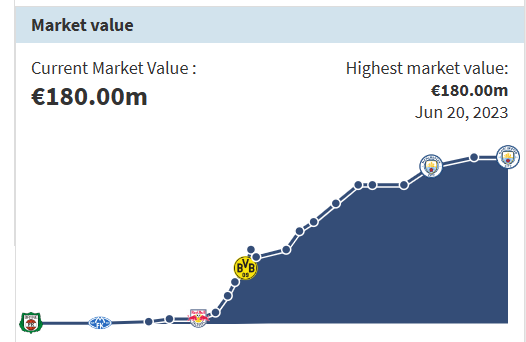

In [32]:
#we replace players_id with the variable player_id to get the data of the player we want
response = requests.get(f'https://www.transfermarkt.com/ceapi/marketValueDevelopment/graph/{player_id}', headers=headers)


In [33]:
#check if we got a 200 response
response.status_code

200

In [34]:
response.json() #we get a dictionary

{'list': [{'x': 1482015600000,
   'y': 200000,
   'mw': '€200k',
   'datum_mw': 'Dec 18, 2016',
   'verein': 'Bryne FK',
   'age': '16',
   'wappen': 'https://tmssl.akamaized.net/images/wappen/profil/1057.png?lm=1480871779'},
  {'x': 1513983600000,
   'y': 300000,
   'mw': '€300k',
   'datum_mw': 'Dec 23, 2017',
   'verein': 'Molde FK',
   'age': '17',
   'wappen': 'https://tmssl.akamaized.net/images/wappen/profil/687.png?lm=1409159512'},
  {'x': 1536530400000,
   'y': 2000000,
   'mw': '€2.00m',
   'datum_mw': 'Sep 10, 2018',
   'verein': 'Molde FK',
   'age': '18',
   'wappen': ''},
  {'x': 1546124400000,
   'y': 5000000,
   'mw': '€5.00m',
   'datum_mw': 'Dec 30, 2018',
   'verein': 'Molde FK',
   'age': '18',
   'wappen': ''},
  {'x': 1559512800000,
   'y': 5000000,
   'mw': '€5.00m',
   'datum_mw': 'Jun 3, 2019',
   'verein': 'Red Bull Salzburg',
   'age': '18',
   'wappen': 'https://tmssl.akamaized.net/images/wappen/profil/409_1557781653.png?lm=1557781653'},
  {'x': 1567461600000

In [35]:
response.json().keys() #get the keys of the dictionary

dict_keys(['list', 'current', 'highest', 'highest_date', 'last_change', 'details_url', 'thread', 'translations'])